In [2]:
import pandas as pd
import os 
import subprocess
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
import src 
from src.dataset import Dataset
from utils import * 
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
import pingouin

%load_ext autoreload 
%autoreload 2

In [8]:
# genome_metadata_df = load_genome_metadata()
pred_out_df = load_pred_out('../data/predict/filter_dataset_test.predict.csv', model_name='filter_esm_650m_gap_v2')
pred_out_df = pred_out_df.merge(pd.read_hdf('../data/filter_dataset_test.h5', key='metadata').drop(columns=['label']), left_index=True, right_index=True, how='left')

In [9]:
def table_1(path:str=None):

    model_names = [model_name.replace('.pkl', '') for model_name in os.listdir('../models/')]
    table_df = list()

    for model_name in model_names:
        pred_out_df = load_pred_out('../data/predict/filter_dataset_test.predict.csv', model_name=model_name)
        row = dict()
        row['feature type'] = re.search('(esm_650m_gap|pt5_3b_gap|esm_3b_gap)', model_name).group(1) 
        row['model_name'] = model_name
        row.update(pred_out_df.confusion_matrix.value_counts().to_dict())
        row['accuracy'] = np.round(balanced_accuracy_score(pred_out_df.label, pred_out_df.model_label), 4)
        table_df.append(row)
    return pd.DataFrame(table_df).set_index('model_name')

table_1().sort_values('false positive')

        

,feature type,true negative,false negative,true positive,false positive,accuracy
model_name,,,,,,
filter_esm_650m_gap_v2,esm_650m_gap,78480,6007,2567,995,0.6434
filter_esm_650m_gap_v1,esm_650m_gap,77378,4590,3984,2097,0.7191


In [5]:
pred_out_df.columns

Index(['model_label', 'model_output_0', 'model_output_1', 'label_x',
       'confusion_matrix', 'cluster_rep', 'cluster', 'n_hits', 'n_valid_hits',
       'n_same_strand_hits', 'ref_locus_tag', 'ref_feature', 'in_frame_hit',
       'start_aligned_hit', 'stop_aligned_hit', 'hit_overlap', 'ref_contig_id',
       'ref_strand', 'ref_start', 'ref_stop', 'ref_partial', 'ref_product',
       'ref_note', 'ref_protein_id', 'ref_seq', 'ref_pseudo', 'ref_inference',
       'ref_experiment', 'ref_evidence_type', 'ref_evidence_category',
       'ref_evidence_details', 'ref_evidence_source', 'ref_used_pgap',
       'ref_genome_id', 'start', 'stop', 'strand', 'ID', 'partial',
       'start_type', 'rbs_motif', 'rbs_spacer', 'gc_content', 'seq',
       'contig_id', 'genome_id', 'interpro_length', 'interpro_analysis',
       'interpro_signature', 'interpro_signature_description',
       'interpro_start', 'interpro_stop', 'interpro_e_value',
       'interpro_status', 'interpro_date', 'interpro_annotation

In [55]:
# Essentially every false positive has a hit in the reference. 
pred_out_fp_df = pred_out_df[pred_out_df.confusion_matrix == 'false positive'].copy() 
pred_out_tp_df = pred_out_df[pred_out_df.confusion_matrix == 'true positive'].copy() 
pred_out_fn_df = pred_out_df[pred_out_df.confusion_matrix == 'false negative'].copy() 
pred_out_tn_df = pred_out_df[pred_out_df.confusion_matrix == 'true negative'].copy() 

print('Number of false positives with a hypothetical protein reference hit:', pred_out_fp_df.apply(is_hypothetical, axis=1).sum())
print('Number of false positives with a putative reference hit:', pred_out_fp_df.apply(is_putative, axis=1).sum())
print(pred_out_fp_df.apply(is_putative, axis=1).sum() / pred_out_fp_df.apply(is_hypothetical, axis=1).sum(), end='\n\n')

print('Total hypothetical protein reference hits:', pred_out_df.apply(is_hypothetical, axis=1).sum())
print('Total hypothetical protein putative reference hits:', pred_out_df.apply(is_putative, axis=1).sum())
print(pred_out_df.apply(is_putative, axis=1).sum() / pred_out_df.apply(is_hypothetical, axis=1).sum(), end='\n\n')


Number of false positives with a hypothetical protein reference hit: 3492
Number of false positives with a putative reference hit: 479
0.13717067583046966

Total hypothetical protein reference hits: 12504
Total hypothetical protein putative reference hits: 7935
0.6345969289827256



In [72]:
# What are the non-hypothetical proteins being misclassified? Might give some hint as to what is going on. 
# Entries with ref_product as "none" will be Prodigal sequences that were validated with InterPro.

# I wonder if this is a homology problem? Do any correctly- and incorrectly-classified sequences have the same annotation?
products = dict()
for confusion_matrix, df in pred_out_df.groupby('confusion_matrix'):
    products[confusion_matrix] = df[~df.apply(is_hypothetical, axis=1)].ref_product.unique()

products_positive = np.unique(np.concatenate([products['true positive'], products['false positive']]))
products_negative = np.unique(np.concatenate([products['true negative'], products['false negative']]))
len(np.intersect1d(products_positive, products_positive))

products_label_1 = pred_out_df[(pred_out_df.label == 1) & ~pred_out_df.apply(is_hypothetical, axis=1)].ref_product.unique()
products_label_0 = pred_out_df[(pred_out_df.label == 0) & ~pred_out_df.apply(is_hypothetical, axis=1)].ref_product.unique()

len(np.intersect1d(products['false positive'], products['true negative']))

1295

In [52]:
print(len(pred_out_fp_df))
print(pred_out_fp_df.apply(is_hypothetical, axis=1).sum())
print((~pred_out_fp_df.apply(is_hypothetical, axis=1)).sum())

8847
3492
5355


In [67]:
from src.tools import MMseqs

mmseqs = MMseqs()
pred_out_df = mmseqs.cluster(pred_out_df, job_name='pred_out', sequence_identity=0.2)
mmseqs.cleanup()

<Axes: ylabel='Density'>

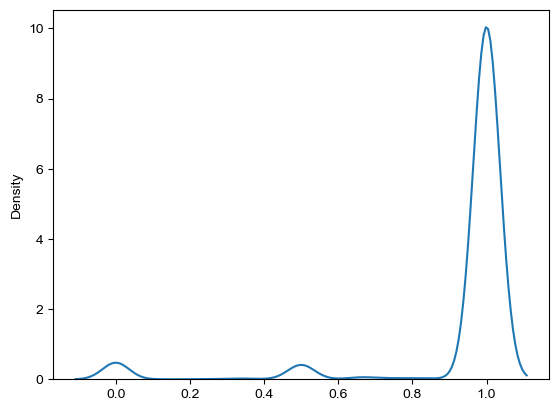

In [ ]:
fig, ax = plt.subplots()

accs = list()
n_singleton_clusters = 0
warnings.simplefilter('ignore')
for cluster, df in pred_out_df.groupby('cluster'):
    if len(df) == 1:
        n_singleton_classes += 1
        continue
    accs += [balanced_accuracy_score(df.label, df.model_label)]

sns.kdeplot(accs, ax=ax)

In [79]:
pred_out_df.cluster.nunique()

39555

/home/prichter/Documents/tripy/notebooks/utils.py:48: UserWarning: get_lengths: Some of the returned lengths are NaNs, which probably means there are sequences that do not have NCBI reference hits.
  warnings.warn('get_lengths: Some of the returned lengths are NaNs, which probably means there are sequences that do not have NCBI reference hits.')


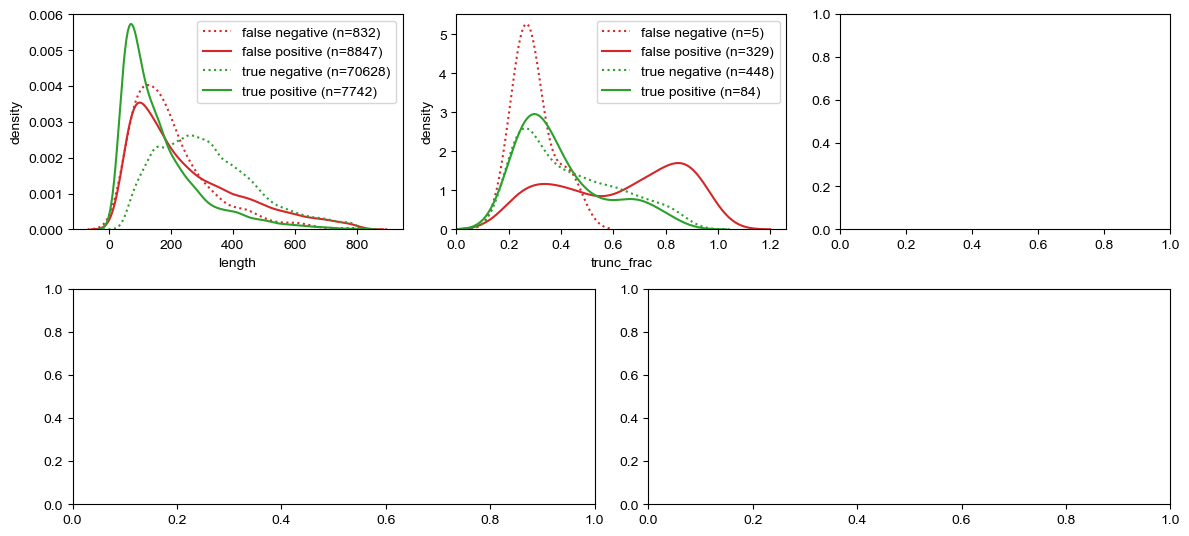

In [44]:
# What fraction of the false positives are sequences with putative hits in the reference that were rescues by InterPro?
# 8000 of the false positives were not putative NCBI, though many were hypothetical proteins. I wonder if I need to do a scan of all hypothetical proteins?
# Or should I just remove them entirely from the training set?
def figure_1(pred_out_df:pd.DataFrame, path:str=None):
    
    # pred_out_df.confusion_matrix = pd.Categorical(pred_out_df.confusion_matrix, ['true positive', 'false negative', 'false positive', 'true negative'], ordered=True)
    df = pred_out_df # [pred_out_df.confusion_matrix.isin(['false positive', 'true positive'])].copy()
    df['ncbi_putative'] = df.apply(is_putative, axis=1)
    df['length'] = get_lengths(df, ref=False)
    df['ref_length'] = get_lengths(df, ref=True)
    df['length_diff'] = df.ref_length - df.length
    df['trunc_frac'] = np.where(df.length_diff > 0, df.length_diff / df.ref_length, 0)

    fig = plt.figure(figsize=(12, 8), layout='tight')
    grid = GridSpec(nrows=3, ncols=6, figure=fig)

    ax_a = fig.add_subplot(grid[0, 0:2])
    ax_b = fig.add_subplot(grid[0, 2:4])
    ax_c = fig.add_subplot(grid[0, 4:6])
    ax_d = fig.add_subplot(grid[1, 0:3])
    ax_e = fig.add_subplot(grid[1, 3:6])

    data = dict()
    data['putative NCBI hits'] = df[df.ncbi_putative]
    data['strong NCBI hits'] = df[~df.ncbi_putative]

    colors = {'true positive':'tab:green', 'false positive':'tab:red', 'true negative':'tab:green', 'false negative':'tab:red'}
    linestyles = {'true positive':'-', 'false positive':'-', 'true negative':':', 'false negative':':'}
    for confusion_matrix, df_ in df.groupby('confusion_matrix'):
        n = len(df_)
        sns.kdeplot(df_.length, ax=ax_a, color=colors[confusion_matrix], ls=linestyles[confusion_matrix], label=f'{confusion_matrix} (n={n})')
    ax_a.legend()
    ax_a.set_ylabel('density')

    for confusion_matrix, df_ in df.groupby('confusion_matrix'):
        min_trunc_frac = 0.2
        n = (df_.trunc_frac > min_trunc_frac).sum() 
        sns.kdeplot(df_.trunc_frac[df_.trunc_frac > min_trunc_frac], ax=ax_b, color=colors[confusion_matrix], ls=linestyles[confusion_matrix], label=f'{confusion_matrix} (n={n})')
    ax_b.legend()
    ax_b.set_ylabel('density')
    ax_b.set_xlim(xmin=0)

    plt.show()

figure_1(pred_out_df)


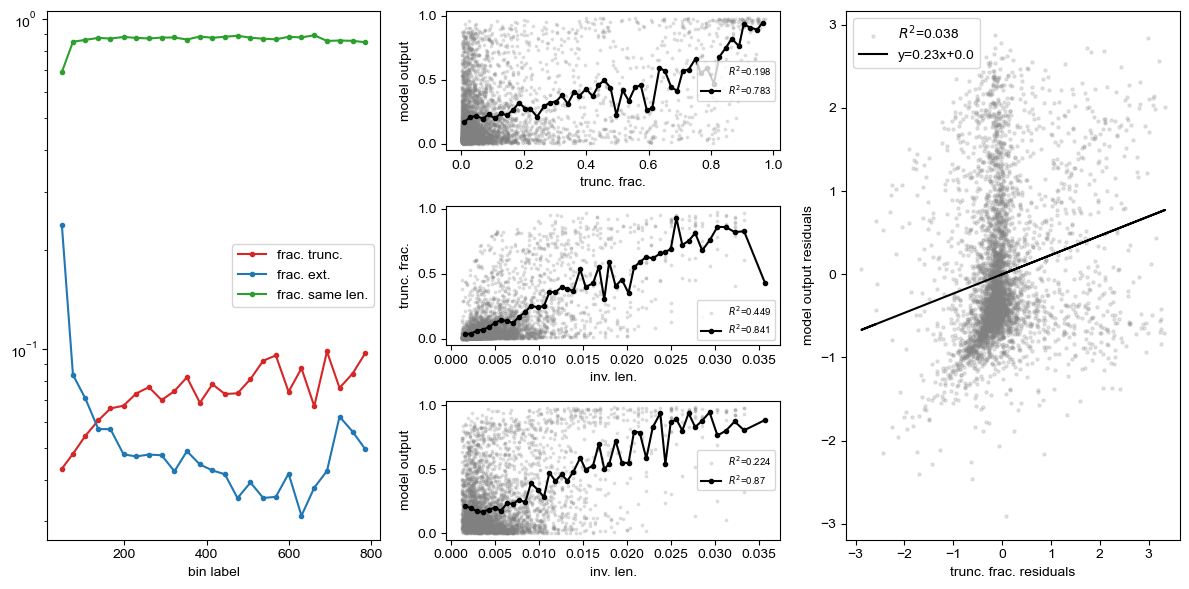

In [ ]:
def figure_2(pred_out_df:pd.DataFrame):

    pred_out_0_df = pred_out_df[pred_out_df.label == 0].copy() # Get all predictions for sequences with a reference equivalent. 

    df = pred_out_df[['model_output_1']].copy()
    df['length'], df['ref_length'] = get_lengths(pred_out_0_df, ref=False), get_lengths(pred_out_0_df, ref=True)
    df['length_diff'] = df.ref_length - df.length
    df['inverse_length'] = 1 / df.length
    df['trunc_size'] = np.where(df.length_diff > 0, df.length_diff, 0) 
    df['trunc_frac'] = df.trunc_size / df.ref_length 

    bin_labels, bin_edges = pd.cut(df.length, bins=25, retbins=True, labels=False)
    df['bin_label'] = bin_labels

    fig = plt.figure(layout='tight', figsize=(10, 6))
    grid = GridSpec(nrows=3, ncols=2, figure=fig)

    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = [fig.add_subplot(grid[i, 1]) for i in range(3)]

    lengths =  df.groupby('bin_label').length.mean() # Get the mean sequence length per bin. 
    ax_a_data = dict()
    ax_a_data['frac. trunc.'] = df.groupby('bin_label').apply(lambda df : (df.length_diff < 0).sum() / len(df), include_groups=False)
    ax_a_data['frac. ext.'] = df.groupby('bin_label').apply(lambda df : (df.length_diff > 0).sum() / len(df), include_groups=False)
    ax_a_data['frac. same len.'] = df.groupby('bin_label').apply(lambda df : (df.length_diff == 0).sum() / len(df), include_groups=False)
    ax_a_colors = {'frac. trunc.':'tab:red', 'frac. ext.':'tab:blue', 'frac. same len.':'tab:green'}

    for label, data in ax_a_data.items():
        ax_a.plot(lengths, data, label=label, color=ax_a_colors[label], marker='o', markersize=3)

    ax_a.set_yscale('log')
    ax_a.set_xlabel('log(frac.)')
    ax_a.set_xlabel('bin label')
    ax_a.legend()

    df = df[df.trunc_size > 0]

    # xy_cols = [('trunc_frac', 'model_output_1'), ('length', 'trunc_frac'), ('length', 'model_output_1')]
    xy_cols = [('trunc_frac', 'model_output_1'), ('inverse_length', 'trunc_frac'), ('inverse_length', 'model_output_1')]
    labels = {'trunc_frac':'trunc. frac.', 'model_output_1':'model output', 'inverse_length':'inv. len.'}

    for (x_col, y_col), ax in zip(xy_cols, ax_b): 
        df_ = denoise(df, x_col=x_col, y_cols=[y_col])
        r2, _ = correlation(df[x_col].values, df[y_col].values)
        # r2_, _ = correlation(df_[x_col].values, df_[y_col].values)
        ax.scatter(df[x_col], df[y_col], color='gray', alpha=0.2, s=3, label='$R^2$=' + str(r2))
        ax.plot(df_[x_col], df_[y_col], color='black', marker='o', markersize=3)
        ax.legend(fontsize='x-small')
        ax.set_xlabel(labels[x_col])
        ax.set_ylabel(labels[y_col])

    x, y, z = df.trunc_frac.values, df.model_output_1.values, df.inverse_length.values
    r2, linreg, (x_residuals, y_residuals) = partial_correlation(x, y, z)
    print('figure_')
    plt.show()



In [20]:
# # First thing I want to look at is the accuracy per genome. 
# fig, axes = plt.subplots(ncols=2, layout='tight', figsize=(8, 4))

# ax = axes[0]
# accs = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label), include_groups=False)
# ax.hist(accs, bins=20, color='gray', width=0.01, edgecolor='black')
# ax.set_xlabel('balanced accuracy')
# ax.set_ylabel('count')

# ax = axes[1]
# labels = ['correct', 'spurious']
# matrix = confusion_matrix(pred_out_df.label.values, pred_out_df.model_label.values) #, labels=sorted(pred_out_df.label.unique()))
# matrix = pd.DataFrame(matrix, columns=labels, index=labels)
# matrix = matrix.apply(lambda x: x/x.sum(), axis=0) # Normalize the matrix.

# sns.heatmap(matrix, ax=ax, annot=True, cbar=False, linecolor='black', lw=0.2, fmt='.1%', cmap='Blues') # fmt='.1%',

# # Rotate the tick labels on the x-axis of each subplot.
# ax.set_xticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=45, ha='right')
# ax.set_yticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=0)
# ax.set_xlabel('predicted label')
# ax.set_ylabel('true label')

# plt.show()

# The UserWarning from scikitlearn is because some of the genomes have no Prodigal false positives in the testing set. 

def table_2(pred_out_df:pd.DataFrame, path:str='../figures/filter-table_1.png'):
    table_df = dict()

    table_df['accuracy'] = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label) , include_groups=False)
    
    for confusion_matrix, df in pred_out_df.groupby('confusion_matrix'):
        table_df[confusion_matrix] = df.groupby('genome_id').apply(len, include_groups=False)
    table_df = pd.DataFrame(table_df).fillna(0)
    table_df = table_df.sort_values('false positive', ascending=False)
    dfi.export(table_df.iloc[:50], path)
    return table_df


table_2(pred_out_df)

124006 bytes written to file /tmp/tmpj_f_j4yh/temp.png


,accuracy,false negative,false positive,true negative,true positive
genome_id,,,,,
GCF_000372745.1,0.661225,175.0,41.0,1628,93
GCF_002706795.1,0.705930,44.0,27.0,839,35
GCF_900129935.1,0.709064,45.0,24.0,888,36
GCF_000271485.2,0.929038,2.0,21.0,844,15
GCF_003697165.2,0.952231,1.0,21.0,850,13
...,...,...,...,...,...
GCF_000504085.1,0.653846,18.0,0.0,367,8
GCF_000020945.1,0.636364,8.0,0.0,285,3
GCF_002688585.1,0.694444,11.0,0.0,206,7


In [ ]:
pred_out_df[pred_out_df.confusion_matrix == 'false positive'].ref_product.value_counts()
pred_out_df[pred_out_df.confusion_matrix == 'true negative'].ref_product.value_counts()

pred_out_fp_df = pred_out_df[pred_out_df.confusion_matrix == 'false positive']
pred_out_tn_df = pred_out_df[pred_out_df.confusion_matrix == 'true negative']

pred_out_df[(pred_out_df.ref_product == 'hypothetical protein') & pred_out_df.ref_seq.isnull()][['ref_pseudo', 'ref_product', 'partial', 'ref_evidence_type', 'ref_partial']]
pred_out_fp_df[(pred_out_fp_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')
pred_out_tn_df[(pred_out_tn_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')

ref_evidence_type
ab initio prediction      6368
similar to AA sequence    3647
protein motif              202
profile                     14
Name: count, dtype: int64

In [11]:
train_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0)
test_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0)

x_train, y_train = train_df.seq.apply(len).values, train_df.label.values
x_test, y_test = test_df.seq.apply(len).values, test_df.label.values

model = LogisticRegression(class_weight='balanced', C=0.001, tol=1e-8)
model.fit(x_train.reshape(-1, 1), y_train)

y_test_pred = model.predict(x_test.reshape(-1, 1))
y_train_pred = model.predict(x_train.reshape(-1, 1))

print('Balanced test accuracy:', balanced_accuracy_score(y_test, y_test_pred.ravel()))
print('Balanced train accuracy:', balanced_accuracy_score(y_train, y_train_pred.ravel()))

Balanced test accuracy: 0.7081700317418668
Balanced train accuracy: 0.70982568099759


In [56]:
model.n_iter_

array([18], dtype=int32)